# Exploring the Molecular Latent Space

In this demo, we will explore how generative models can allow us to generate and explore new molecular structures. In particular, we will use a encoder decoder style RNN described in Krenn et al.'s [SELFIES paper](https://iopscience.iop.org/article/10.1088/2632-2153/aba947). By modifying molecular representations in the latent space, we will be able to generate novel molecules. Note that we will train from scratch and so our model will have terrible performance.

Also note that much of this code is adapted from the [SELFIES repo](https://github.com/aspuru-guzik-group/selfies) where it is licensed under the [APACHE license](https://github.com/aspuru-guzik-group/selfies/blob/master/LICENSE).

Making this demo work will require the installation of pytorch as well as a few cheminformatics and utility packages. The packages are listed below and can be installed via pip or conda.
- selfies
- rdkit
- PYyaml
- pytorch
- pandas

In [1]:
import torch
from torch import nn
from rdkit import Chem
import selfies as sf

from utils import (
    get_selfie_and_smiles_encodings_for_dataset,
    multiple_selfies_to_hot,
    train_model,
    one_hot_to_mol,
    smile_to_one_hot
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First we will define a fairly standard 3-layer RNN. Later on you will be able to alter the model architecture. We will be using the SELFIES molecular string encoding which has an 18 character alphabet that will be one-hot-encoded.

In [2]:
class VAEEncoder(nn.Module):

    def __init__(self, in_dimension, layer_1d, layer_2d, layer_3d,
                 latent_dimension):
        """
        Fully Connected layers to encode molecule to latent space
        """
        super(VAEEncoder, self).__init__()
        self.latent_dimension = latent_dimension

        # Reduce dimension up to second last layer of Encoder
        self.encode_nn = nn.Sequential(
            nn.Linear(in_dimension, layer_1d),
            nn.ReLU(),
            nn.Linear(layer_1d, layer_2d),
            nn.ReLU(),
            nn.Linear(layer_2d, layer_3d),
            nn.ReLU()
        )

        # Latent space mean
        self.encode_mu = nn.Linear(layer_3d, latent_dimension)

        # Latent space variance
        self.encode_log_var = nn.Linear(layer_3d, latent_dimension)

    @staticmethod
    def reparameterize(mu, log_var):
        """
        This trick is explained well here:
            https://stats.stackexchange.com/a/16338
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        """
        Pass throught the Encoder
        """
        # Get results of encoder network
        h1 = self.encode_nn(x)

        # latent space
        mu = self.encode_mu(h1)
        log_var = self.encode_log_var(h1)

        # Reparameterize
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

Next we define a decoder gated recurrent unit (GRU) with a fully connected layer on top. This will use our latent space and a hidden state to generate new SELFIES.

In [3]:
class VAEDecoder(nn.Module):

    def __init__(self, latent_dimension, gru_stack_size, gru_neurons_num,
                 out_dimension):
        """
        Through Decoder
        """
        super(VAEDecoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.gru_stack_size = gru_stack_size
        self.gru_neurons_num = gru_neurons_num

        # Simple Decoder
        self.decode_RNN = nn.GRU(
            input_size=latent_dimension,
            hidden_size=gru_neurons_num,
            num_layers=gru_stack_size,
            batch_first=False)

        self.decode_FC = nn.Sequential(
            nn.Linear(gru_neurons_num, out_dimension),
        )

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters())
        return weight.new_zeros(self.gru_stack_size, batch_size,
                                self.gru_neurons_num)

    def forward(self, z, hidden):
        """
        A forward pass throught the entire model.
        """

        # Decode
        l1, hidden = self.decode_RNN(z, hidden)
        decoded = self.decode_FC(l1)  # fully connected layer

        return decoded, hidden


In [5]:
# we will use a subsection of the popular QM9 dataset.
file_name_smiles = '0SelectedSMILES_QM9.txt'

# this will use a SMILES encoding
type_of_encoding = 0

print('Representation: SELFIES')
encoding_list, encoding_alphabet, largest_molecule_len, _, _, _ = \
    get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

print('--> Creating one-hot encoding...')
data = multiple_selfies_to_hot(encoding_list, largest_molecule_len,
                               encoding_alphabet)
print('Finished creating one-hot encoding.')


len_max_molec = data.shape[1]
len_alphabet = data.shape[2]
len_max_mol_one_hot = len_max_molec * len_alphabet

print(' ')
print(f"Alphabet has {len_alphabet} letters, "
      f"largest molecule is {len_max_molec} letters.")

Representation: SELFIES
--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
--> Creating one-hot encoding...
Finished creating one-hot encoding.
 
Alphabet has 18 letters, largest molecule is 21 letters.


We can modify training hyperparameters with these dicitionaries.

In [6]:
batch_size = 100

decoder_parameters = {
  'latent_dimension': 50,
  'gru_neurons_num': 99,
  'gru_stack_size': 1,
}

encoder_parameters = {
  'layer_1d': 100,
  'layer_2d': 100,
  'layer_3d': 100,
  'latent_dimension': 50
}

training_parameters = {
  'KLD_alpha': 1.0e-05,
  'lr_enc': 0.0001,
  'lr_dec': 0.0001,
  'num_epochs': 3, # not nearly enough to get decent performance
  'sample_num': 1000
}

First we will define our encoder and decoder networks and put them on our device (if available).

In [7]:
vae_encoder = VAEEncoder(in_dimension=len_max_mol_one_hot,
                         **encoder_parameters).to(device)
vae_decoder = VAEDecoder(**decoder_parameters,
                         out_dimension=len(encoding_alphabet)).to(device)

Next we will train our model, the specifics of this process are in the `utils.py` file and you can look if interested.

In [8]:
data = torch.tensor(data, dtype=torch.float).to(device)

train_valid_test_size = [0.5, 0.5, 0.0]
data = data[torch.randperm(data.size()[0])]
idx_train_val = int(len(data) * train_valid_test_size[0])
idx_val_test = idx_train_val + int(len(data) * train_valid_test_size[1])

data_train = data[0:idx_train_val]
data_valid = data[idx_train_val:idx_val_test]

print("start training")
train_model(**training_parameters,
            vae_encoder=vae_encoder,
            vae_decoder=vae_decoder,
            batch_size=batch_size,
            data_train=data_train,
            data_valid=data_valid,
            alphabet=encoding_alphabet,
            type_of_encoding=type_of_encoding,
            sample_len=len_max_molec,
            device=device)


start training
num_epochs:  3
Epoch: 0,  Batch: 0 / 660,	(loss: 2.9389	| quality: 5.7143 | quality_valid: 4.5238)	ELAPSED TIME: 0.34511
Epoch: 0,  Batch: 30 / 660,	(loss: 2.8702	| quality: 7.6190 | quality_valid: 8.1200)	ELAPSED TIME: 0.61871
Epoch: 0,  Batch: 60 / 660,	(loss: 2.7987	| quality: 16.7619 | quality_valid: 17.7562)	ELAPSED TIME: 0.63000
Epoch: 0,  Batch: 90 / 660,	(loss: 2.5642	| quality: 31.8095 | quality_valid: 33.7829)	ELAPSED TIME: 0.71695
Epoch: 0,  Batch: 120 / 660,	(loss: 2.0051	| quality: 39.4286 | quality_valid: 40.5467)	ELAPSED TIME: 0.62485
Epoch: 0,  Batch: 150 / 660,	(loss: 1.8078	| quality: 54.2857 | quality_valid: 53.4571)	ELAPSED TIME: 0.65467
Epoch: 0,  Batch: 180 / 660,	(loss: 1.6932	| quality: 57.1905 | quality_valid: 56.2171)	ELAPSED TIME: 0.67614
Epoch: 0,  Batch: 210 / 660,	(loss: 1.6215	| quality: 59.5238 | quality_valid: 58.7105)	ELAPSED TIME: 0.67481
Epoch: 0,  Batch: 240 / 660,	(loss: 1.5219	| quality: 60.4286 | quality_valid: 60.4705)	ELAPSED TIM

[11:45:27] SMILES Parse Error: syntax error while parsing: [#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:45:27] SMILES Parse Error: Failed parsing SMILES '[#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][#Branch1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]'
[11:45:27] SMILES Parse Error: syntax error while parsing: [nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:45:27] SMILES Parse Error: Failed parsing SMILES '[nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][n

Validity: 1.60000 % | Diversity: 0.40000 % | Reconstruction: 65.34857 %
Epoch: 1,  Batch: 0 / 660,	(loss: 1.2439	| quality: 64.0952 | quality_valid: 65.3638)	ELAPSED TIME: 0.03962
Epoch: 1,  Batch: 30 / 660,	(loss: 1.1935	| quality: 65.6667 | quality_valid: 65.7581)	ELAPSED TIME: 1.09072
Epoch: 1,  Batch: 60 / 660,	(loss: 1.1984	| quality: 66.7143 | quality_valid: 65.6324)	ELAPSED TIME: 0.73398
Epoch: 1,  Batch: 90 / 660,	(loss: 1.2210	| quality: 65.1905 | quality_valid: 66.0076)	ELAPSED TIME: 0.63487
Epoch: 1,  Batch: 120 / 660,	(loss: 1.1805	| quality: 65.9524 | quality_valid: 65.3752)	ELAPSED TIME: 0.64955
Epoch: 1,  Batch: 150 / 660,	(loss: 1.1786	| quality: 66.0000 | quality_valid: 65.5181)	ELAPSED TIME: 0.70665
Epoch: 1,  Batch: 180 / 660,	(loss: 1.2121	| quality: 65.0952 | quality_valid: 65.6095)	ELAPSED TIME: 0.63240
Epoch: 1,  Batch: 210 / 660,	(loss: 1.1679	| quality: 66.5238 | quality_valid: 65.8076)	ELAPSED TIME: 0.68192
Epoch: 1,  Batch: 240 / 660,	(loss: 1.1937	| quality:

[11:45:53] SMILES Parse Error: syntax error while parsing: [C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:45:53] SMILES Parse Error: Failed parsing SMILES '[C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]'
[11:45:53] SMILES Parse Error: syntax error while parsing: [C][Ring1][Ring1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:45:53] SMILES Parse Error: Failed parsing SMILES '[C][Ring1][Ring1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[C][Ring1][Ring1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]'
[11:45:53] SMILES Parse Error: syntax error while parsing: [#Branch1][F][F][F][F][C][C][C][C][C][C][C][C][C][C][C][C

Validity: 2.50000 % | Diversity: 0.60000 % | Reconstruction: 65.71238 %
Epoch: 2,  Batch: 0 / 660,	(loss: 1.1868	| quality: 65.4762 | quality_valid: 65.5790)	ELAPSED TIME: 0.03536
Epoch: 2,  Batch: 30 / 660,	(loss: 1.2096	| quality: 64.0952 | quality_valid: 65.5314)	ELAPSED TIME: 0.65016
Epoch: 2,  Batch: 60 / 660,	(loss: 1.1901	| quality: 64.6190 | quality_valid: 65.6533)	ELAPSED TIME: 0.63420
Epoch: 2,  Batch: 90 / 660,	(loss: 1.1493	| quality: 66.2381 | quality_valid: 65.9238)	ELAPSED TIME: 0.61980
Epoch: 2,  Batch: 120 / 660,	(loss: 1.1481	| quality: 65.8571 | quality_valid: 65.5010)	ELAPSED TIME: 0.62326
Epoch: 2,  Batch: 150 / 660,	(loss: 1.1485	| quality: 66.0952 | quality_valid: 65.6838)	ELAPSED TIME: 0.63585
Epoch: 2,  Batch: 180 / 660,	(loss: 1.1174	| quality: 67.2381 | quality_valid: 65.4876)	ELAPSED TIME: 0.65672
Epoch: 2,  Batch: 210 / 660,	(loss: 1.1958	| quality: 64.7143 | quality_valid: 65.5276)	ELAPSED TIME: 0.66369
Epoch: 2,  Batch: 240 / 660,	(loss: 1.1760	| quality:

[11:46:19] SMILES Parse Error: syntax error while parsing: [Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][nop][nop]
[11:46:19] SMILES Parse Error: Failed parsing SMILES '[Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][nop][nop]' for input: '[Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][nop][nop]'
[11:46:19] SMILES Parse Error: syntax error while parsing: [O][O][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:46:19] SMILES Parse Error: Failed parsing SMILES '[O][O][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[O][O][O][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]'
[11:46:19] SMILES Pa

Validity: 1.40000 % | Diversity: 0.40000 % | Reconstruction: 65.80762 %


[11:46:23] SMILES Parse Error: syntax error while parsing: [C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
[11:46:23] SMILES Parse Error: Failed parsing SMILES '[C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]' for input: '[C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]'
[11:46:23] SMILES Parse Error: syntax error while parsing: [Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1]
[11:46:23] SMILES Parse Error: Failed parsing SMILES '[Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1]' for input: '[Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring

Here is where things get interesting. We can input any molecule we are interested in by specifying the appropriate SELFIE string. In this case, we will start with a SMILE, convert it into a SMILE, and then feed it into our encoder. Below I am using ethanol but if you'd like to explore a different molecule you can draw a molecule and covert it to a SMILE using [LigParGen](http://zarbi.chem.yale.edu/ligpargen/moleculeDraw.html).

We will then convert this SMILE to a one-hot-encoding in the SELFIES style representation.

In [9]:
input_smile = "CCO"

hot = smile_to_one_hot(input_smile, largest_molecule_len, encoding_alphabet)
hot.shape

torch.Size([1, 21, 18])

This does give us the expected shape, with dimensions of batch size, largest molecule, and alphabet size.

Using rdkit, we can also visualize our molecule.

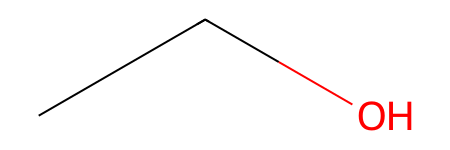

In [10]:
Chem.MolFromSmiles(input_smile)

Next let's create a latent representation using the encoder! Here we will need to insert an extra singleton dimension to imitate the batch size.

In [11]:
hot = smile_to_one_hot(input_smile, largest_molecule_len, encoding_alphabet)

latent_representation = vae_encoder(torch.flatten(hot, 1))[0]

latent_w_fake_batch = torch.unsqueeze(latent_representation, 0)

latent_w_fake_batch.shape

torch.Size([1, 1, 50])

This is a 50-dimensional encoding of our molecule! The first two dimensions are the batch size and the GRU stack size.

Next let's decode our latent space and see how we did! Again, we will be using the SMILES representation because they are a bit easier to read. First we initialize the hidden state and then iterate until we have generated a full sequence.

In [12]:
hidden = vae_decoder.init_hidden(batch_size=1)

# decoding from RNN N times, where N is the length of the largest
# molecule (all molecules are padded)
out_one_hot = torch.zeros((1, len_max_molec, len_alphabet), device=device)
for seq_index in range(len_max_molec):
    out_one_hot_line, hidden = vae_decoder(latent_w_fake_batch, hidden)
    out_one_hot[:, seq_index, :] = out_one_hot_line[0]

This yields a one-hot-encoding. Let's convert that into a SMILE and draw it to see how we did.

CCC


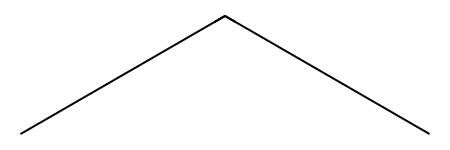

In [13]:
selfie = one_hot_to_mol(out_one_hot, encoding_alphabet)
smile = sf.decoder(selfie)
print(smile)
Chem.MolFromSmiles(smile)

We got the length right, but the chemistry wrong. Given that we barely trained our model at all, that's not bad. Let's try modifying the latent representation and seeing what changes.

CCCCC=C


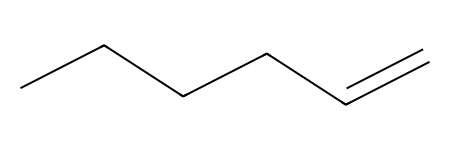

In [14]:
new_latent = latent_w_fake_batch * 2

hidden = vae_decoder.init_hidden(batch_size=1)

# decoding from RNN N times, where N is the length of the largest
# molecule (all molecules are padded)
out_one_hot = torch.zeros((1, len_max_molec, len_alphabet), device=device)
for seq_index in range(len_max_molec):
    out_one_hot_line, hidden = vae_decoder(new_latent, hidden)
    out_one_hot[:, seq_index, :] = out_one_hot_line[0]

selfie = one_hot_to_mol(out_one_hot, encoding_alphabet)
smile = sf.decoder(selfie)
print(smile)
Chem.MolFromSmiles(smile)

Our model has generated a brand new molecule! We can now head to lab and start synthesizing!

While obviously our model performed pretty poorly, this overall approach of exploring molecular latent spaces is quite common in AI for chemistry. Prior work has found that in a properly trained model, nearby points in the latent space have similar chemical properties, meaning our latent representation is really encoding chemistry.

The next step would be to start optimizing a property across the latent space using a gradient-free optimization technique like Gaussian processes.

Hopefully this toy example has taught you something about how chemists are using AI to design brand new molecules!